In [207]:
import os, time, itertools
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from scipy import sparse
from scipy.sparse.linalg import inv
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler import transpile, assemble
from qiskit.quantum_info import DensityMatrix
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
from operators.pauli_hamiltonian import PauliHamiltonian
from quantum_circuit.trotterization import trotter_electric, trotter_coupling, trotter_plaquette
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from utils.matrix_operations import *
from utils.circuits import *
from quantum_info.expectation import expectation
from quantum_info.mitigation_gate import noise_mitigation_gate

In [56]:
sig = []
sig.append(np.eye(2))
sig.append(np.array([[0, 1], [1, 0]]))
sig.append(np.array([[0, -1j], [1j, 0]]))
sig.append(np.array([[1, 0], [0, -1]]))

In [55]:
# 2 triangle plaquettes
T = 0.1
n_steps = 1
g = 0.5
alpha = 1
n_layers = 2
coef_doubler = 2 if n_layers == 2 else 1
H = TrianglePlaquetteHamiltonian(g, alpha, n_layers)

In [57]:
def dec_to_binary_str(dec, n_dig):
    s = bin(dec).replace("0b", "")
    return '0'*(n_dig - len(s)) +s 
    

In [136]:
backend = Aer.get_backend('qasm_simulator')

In [6]:
# Load IBMQ account
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q-ornl', project='brookhaven')
print(provider.backends())
#device_backend = provider.get_backend('ibmq_16_melbourne')
device_backend = provider.get_backend('ibmq_johannesburg')
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
basis_gates = noise_model.basis_gates
device_backend

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>]
[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_johannesburg') from IBMQ(hu

<IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>

In [58]:
def physical_trotter_plaquette(circ, target_indices, coef, deltaT):
    """
    Trotter step for one plaquette term
    S^+ otimes S^+ otimes S^+ + h.c.
    
    Assume the lattice structure is 0 - 1 - 2
    
    
    Arguments:
    circ: qiskit.QuantumCircuit, the target circuit
    qr: qiskit.QunatumRegister, the input qubit state
    target_inidices: list of int, the target indices of the plaquette
    coef: float, coefficient corresponding to the plaquette term
    deltaT: small time step
    Return:
    qiskit.QuantumCircuit, the circuit after added the trotterization step.
    """ 
    assert(len(target_indices)==3), "List of target indices for a plaquette term with invalid length is given."
    # Add cnot gates to target qubits
    for i in range(2):
        circ.cx(target_indices[i+1], target_indices[i])
        circ.u3(np.pi, 0, np.pi, target_indices[i])    
    # Add CCRX gate
    circ = add_crx(circ, coef*deltaT/2, target_indices[1], target_indices[2])
    circ.cx(target_indices[0], target_indices[1])
    circ = add_crx(circ, -coef*deltaT/2, target_indices[1], target_indices[2])
    circ.cx(target_indices[0], target_indices[1])
    circ = add_swap(circ, target_indices[0], target_indices[1]) # Swap 0 and 1
    circ = add_crx(circ, coef*deltaT/2, target_indices[1], target_indices[2])
    circ = add_swap(circ, target_indices[0], target_indices[1]) # Swap back
    
    # Add cnot gates to target qubits
    for i in range(2)[::-1]:
        circ.u3(np.pi, 0, np.pi, target_indices[i])
        circ.cx(target_indices[i+1], target_indices[i])
    
    return circ

def physical_trotter_circ(circ, target_indices, g, alpha, T, n_steps, mitigation_dict, unitary_sim = False):
    """
    For a device with the lattice substructure of six qubits as
    0 - 3 - 1
    |       |
    2 - 5 - 4
    (the indices are those of target_indices)
    
    E, XY interactions between 0-3, 1-4, 2-5
    SWAP 1 and 3
    Plaquette interactions between 2-0-3, 5-4-1 
    Arguments:
    circ: qiskit.QuantumCircuit, the target circuit
    target_inidices: list of int, the target indices of qubits. target_indices[logical_q] = physical_qr
    g: float, the value of g
    alpha: float, the value of alpha
    T: float, the evolution time
    n_steps: int, the number of Trotter steps
    mitigation_dict: dict, dictionary specifying the pauli gate for mitigation. E.g. {'0E03' : 'XY', '1XY14': 'YZ', 1B012': 'ZXX'} the first integer specifies the target step
    
    """
    deltaT = T/n_steps
    for stp in range(n_steps):
        for j in range(3):
            circ = trotter_electric(circ, [target_indices[j], target_indices[j+3]], 2*g**2/2, deltaT, unitary_sim, further_opt=True)
            mit = mitigation_dict.get('%dE%d'%(stp, j), 'II')
            for i in range(2):
                if mit[i] == 'X':
                    circ.u3(np.pi, 0, np.pi, target_indices[3*i+j])
                elif mit[i] == 'Y':
                    circ.u3(np.pi, np.pi/2, np.pi/2, target_indices[3*i+j])
                elif mit[i] == 'Z':
                    circ.u1(np.pi, target_indices[3*i+j])
                
            circ = trotter_coupling(circ, [target_indices[j+3], target_indices[j]], 2*alpha/(2*g**2), deltaT, further_opt=True)
            mit = mitigation_dict.get('%dXY%d'%(stp, j), 'II')
            for i in range(2):
                if mit[i] == 'X':
                    circ.u3(np.pi, 0, np.pi, target_indices[3*i+j])
                elif mit[i] == 'Y':
                    circ.u3(np.pi, np.pi/2, np.pi/2, target_indices[3*i+j])
                elif mit[i] == 'Z':
                    circ.u1(np.pi, target_indices[3*i+j])
                
            mit = mitigation_dict.get('%dEXY%d'%(stp, j), 'II')
            for i in range(2):
                if mit[i] == 'X':
                    circ.u3(np.pi, 0, np.pi, target_indices[3*i+j])
                elif mit[i] == 'Y':
                    circ.u3(np.pi, np.pi/2, np.pi/2, target_indices[3*i+j])
                elif mit[i] == 'Z':
                    circ.u1(np.pi, target_indices[3*i+j])
    
        circ = add_swap(circ, target_indices[1], target_indices[3]) # Swap 1 and 3
        mit = mitigation_dict.get('%dSWAP0'%stp, 'II')
        for i, trg in enumerate([1, 3]):
            if mit[i] == 'X':
                circ.u3(np.pi, 0, np.pi, target_indices[trg])
            elif mit[i] == 'Y':
                circ.u3(np.pi, np.pi/2, np.pi/2, target_indices[trg])
            elif mit[i] == 'Z':
                circ.u1(np.pi, target_indices[trg])
                
        circ = physical_trotter_plaquette(circ, [target_indices[2], target_indices[0], target_indices[3]], -1/(2*g**2), deltaT)
        mit = mitigation_dict.get('%dB0'%stp, 'III')
        for i in range(3):
            if mit[i] == 'X':
                circ.u3(np.pi, 0, np.pi, target_indices[i])
            elif mit[i] == 'Y':
                circ.u3(np.pi, np.pi/2, np.pi/2, target_indices[i])
            elif mit[i] == 'Z':
                circ.u1(np.pi, target_indices[i])
                
        circ = physical_trotter_plaquette(circ, [target_indices[5], target_indices[4], target_indices[1]], -1/(2*g**2), deltaT)
        mit = mitigation_dict.get('%dB1'%stp, 'III')
        for i in range(3):
            if mit[i] == 'X':
                circ.u3(np.pi, 0, np.pi, target_indices[3+i])
            elif mit[i] == 'Y':
                circ.u3(np.pi, np.pi/2, np.pi/2, target_indices[3+i])
            elif mit[i] == 'Z':
                circ.u1(np.pi, target_indices[3+i])
                
        circ = add_swap(circ, target_indices[1], target_indices[3]) # Swap back
        mit = mitigation_dict.get('%dSWAP1'%stp, 'II')
        mit = mitigation_dict.get('%dSWAP0'%stp, 'II')
        for i, trg in enumerate([1, 3]):
            if mit[i] == 'X':
                circ.u3(np.pi, 0, np.pi, target_indices[trg])
            elif mit[i] == 'Y':
                circ.u3(np.pi, np.pi/2, np.pi/2, target_indices[trg])
            elif mit[i] == 'Z':
                circ.u1(np.pi, target_indices[trg])
    return circ
    

# Circuit Components

In [59]:
def electric_circ(circ, input_mapping, unitary_sim = False):
    circ = trotter_electric(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*g**2/2, deltaT=T/n_steps, unitary_sim=unitary_sim, further_opt = True)
    return circ

def coupling_circ(circ, input_mapping, unitary_sim = False):
    circ = trotter_coupling(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*alpha/(2*g**2), deltaT=T/n_steps, further_opt = True)
    return circ

def exy_circ(circ, input_mapping, unitary_sim = False):
    circ = trotter_electric(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*g**2/2, deltaT=T/n_steps, unitary_sim=unitary_sim, further_opt = True)
    circ = trotter_coupling(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*alpha/(2*g**2), deltaT=T/n_steps, further_opt = True)
    return circ

def plaquette_circ(circ, input_mapping, unitary_sim = False):
    circ = physical_trotter_plaquette(circ=circ, target_indices=input_mapping, coef=-1/(2*g**2), deltaT=T/n_steps)
    return circ

def trotter_circ(circ, input_mapping, unitary_sim = False):
    circ = physical_trotter_circ(circ, input_mapping, g, alpha, 0.1, 1, {}, unitary_sim = False)
    return circ

# Noise Mitigation

## Electric term 0-3

In [ ]:
chi_eps_inv_electric = noise_mitigation_gate(electric_circ, 2, device_backend, input_mapping=[5, 6], simulation=False)
print(np.sum(chi_eps_inv_electric))
print(chi_eps_inv_electric)

Job set name: 2020-04-05T07:33:33.379080
          ID: c0aed9aaacd140409be6e614dc5ef1e3-15860720133790803
        tags: []
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-539
    job index: 0
    status: job is being initialized


In [50]:
chi_eps_inv_electric = np.array([[ 1.09124066e+00-1.25846675e-20j],
 [-9.10717578e-03-8.31964275e-21j],
 [-1.22078192e-02-6.15576996e-21j],
 [-1.35281630e-02-9.86775221e-21j],
 [-1.24115224e-02+3.94503504e-21j],
 [ 7.25276047e-05+1.27601271e-20j],
 [-1.96858228e-03+1.35842655e-20j],
 [-1.79975331e-04+4.07344594e-21j],
 [-1.18548579e-02+6.64085914e-22j],
 [ 2.49047430e-03+9.65997179e-21j],
 [ 8.39370114e-04+1.18667882e-20j],
 [-1.00354272e-02+2.90250770e-21j],
 [-1.55408218e-02-8.41852989e-21j],
 [-2.84109124e-03-3.43978514e-21j],
 [ 3.91880454e-04-2.67926302e-21j],
 [-5.35947661e-03-7.99081680e-21j]])

## Electric term 1-4

In [ ]:
chi_eps_inv_electric1 = noise_mitigation_gate(electric_circ, 2, device_backend, input_mapping=[7, 12], simulation=False)
print(np.sum(chi_eps_inv_electric1))
print(chi_eps_inv_electric1)

In [ ]:
chi_eps_inv_electric1 = np.array([[ 1.08401867e+00-4.22797927e-21j],
 [-9.49608277e-03+9.98519598e-21j],
 [-9.70545031e-03+9.48017550e-21j],
 [-1.56822638e-02-4.65509605e-21j],
 [-1.55895054e-02-6.00361470e-21j],
 [-1.88885204e-03+6.91544804e-22j],
 [-3.85959323e-03+1.08024304e-21j],
 [-2.36559118e-03-5.56166990e-21j],
 [-9.86471375e-03-5.54679606e-21j],
 [-3.56972681e-03+1.23476591e-21j],
 [ 1.56703804e-04+5.29276868e-22j],
 [-4.17844126e-03-6.24004321e-21j],
 [-8.70691512e-03-5.48181477e-21j],
 [ 2.04214301e-03+9.48060127e-21j],
 [ 7.15115192e-04+1.00971016e-20j],
 [-2.02549799e-03-4.86189096e-21j]])

## Electric term 2-5

In [ ]:
chi_eps_inv_electric2 = noise_mitigation_gate(electric_circ, 2, device_backend, input_mapping=[10, 11], simulation=False)
print(np.sum(chi_eps_inv_electric2))
print(chi_eps_inv_electric2)

In [ ]:
chi_eps_inv_electric2 = np.array([[ 1.09307105e+00-2.26752716e-21j],
 [-1.29001139e-02+2.62456071e-21j],
 [-8.26271215e-03-2.17850681e-21j],
 [-1.73048273e-02-6.73299582e-21j],
 [-1.49946535e-02-1.33253633e-21j],
 [ 1.31141817e-04+1.37625198e-21j],
 [-1.42528318e-02+5.86328509e-21j],
 [ 1.94879606e-03+3.22962718e-21j],
 [-1.50571312e-02+3.17470670e-21j],
 [ 1.23301362e-03+5.80440648e-21j],
 [ 1.32802055e-03+1.32210843e-21j],
 [ 1.85318190e-03-1.27410157e-21j],
 [-1.17043451e-02-6.63242013e-21j],
 [-4.64214529e-04-2.48316212e-21j],
 [-9.02146872e-04+1.94041443e-21j],
 [-3.72222782e-03-2.43411106e-21j]])

## Coupling term 0-3

In [ ]:
chi_eps_inv_coupling = noise_mitigation_gate(coupling_circ, 2, device_backend, input_mapping=[5, 6], simulation=False)
print(np.sum(chi_eps_inv_coupling))
print(chi_eps_inv_coupling)

In [ ]:
chi_eps_inv_coupling = np.array([[ 1.10863784e+00-7.22700753e-20j],
 [-8.51835588e-03+9.10445954e-19j],
 [-1.40777325e-02-2.88432713e-19j],
 [-1.49704265e-02-1.30285754e-19j],
 [-1.54430111e-02+8.78163129e-19j],
 [-4.42404747e-03-1.24579114e-19j],
 [-1.52537052e-03-1.02911856e-19j],
 [ 6.25843566e-04-3.15407163e-19j],
 [-1.35648643e-02-3.30208041e-19j],
 [-3.96287642e-03-1.21507470e-19j],
 [-4.04911493e-03-1.15560986e-19j],
 [-1.04514157e-03+8.35757524e-19j],
 [-1.53633954e-02-1.73123629e-19j],
 [-3.61731465e-03-2.89246921e-19j],
 [ 3.55004300e-03+8.51441967e-19j],
 [-1.22520766e-02-5.30300796e-20j]])

## Coupling term 1-4

In [ ]:
chi_eps_inv_coupling1 = noise_mitigation_gate(coupling_circ, 2, device_backend, input_mapping=[7, 12], simulation=False)
print(np.sum(chi_eps_inv_coupling1))
print(chi_eps_inv_coupling1)

In [ ]:
chi_eps_inv_coupling1 = np.array([[ 1.10112653-3.32176922e-19j],
 [-0.00912275+7.44658629e-19j],
 [-0.0094082 -2.39813357e-19j],
 [-0.01064158+1.76638546e-19j],
 [-0.00834341+6.83516244e-19j],
 [-0.00330374-3.75914211e-19j],
 [-0.00135276+9.70449900e-20j],
 [ 0.00201786-2.23918528e-19j],
 [-0.01633133-2.36198475e-19j],
 [-0.0050146 +1.07443330e-19j],
 [-0.002402  -3.64679214e-19j],
 [-0.00311682+6.81600799e-19j],
 [-0.01446512+1.83718838e-19j],
 [-0.00229869-2.35061145e-19j],
 [-0.00453625+7.54516585e-19j],
 [-0.01280714-3.22611843e-19j]])

## Coupling term 2-5

In [ ]:
chi_eps_inv_coupling2 = noise_mitigation_gate(coupling_circ, 2, device_backend, input_mapping=[10, 11], simulation=False)
print(np.sum(chi_eps_inv_coupling2))
print(chi_eps_inv_coupling2)

In [ ]:
chi_eps_inv_coupling2 = np.array([[ 1.19639812-1.86017889e-19j],
 [-0.01999357+6.42261800e-19j],
 [-0.01448874-2.11141677e-19j],
 [-0.02510675+6.35332416e-20j],
 [-0.01169747+5.83460601e-19j],
 [-0.00518013-2.78617550e-19j],
 [-0.00796772-3.48880400e-20j],
 [-0.01074926-2.39658167e-19j],
 [-0.01767707-2.23220641e-19j],
 [-0.01646541-4.16405181e-20j],
 [-0.00235958-3.15083672e-19j],
 [-0.0028978 +5.78771722e-19j],
 [-0.01224916+3.59223564e-20j],
 [-0.00621589-1.76061140e-19j],
 [-0.02436371+6.41657872e-19j],
 [-0.01898587-2.13804565e-19j]])

## Plaquette term 0-1-2

In [ ]:
chi_eps_inv_plaquette = noise_mitigation_gate(plaquette_circ, 3, device_backend, input_mapping=[10, 5, 6], simulation=False)
print(np.sum(chi_eps_inv_plaquette))
print(chi_eps_inv_plaquette)

In [20]:
chi_eps_inv_plaquette = np.array([[1.22631054-8.40175009e-21j] ,
[-0.04585796-6.01761299e-19j] ,
[-0.04845319+1.49976885e-19j] ,
[-0.0469879+8.52588355e-20j] ,
[-0.03340243-1.8519752e-19j] ,
[-0.04484125+8.06876777e-20j] ,
[-0.00675863-2.85590347e-21j] ,
[-0.00291143-5.74607207e-20j] ,
[-0.01662736-7.97199142e-21j] ,
[-0.01670473-8.81238541e-20j] ,
[0.00400338+1.90548773e-19j] ,
[-0.01341668-9.78827095e-20j] ,
[-0.01309329-3.46823593e-19j] ,
[0.00169178+4.71093336e-19j] ,
[-0.01751788-1.40287819e-19j] ,
[-0.01568514+2.00303428e-19j] ,
[-0.05703623+4.2322157e-19j] ,
[0.00547501+5.82372021e-20j] ,
[0.01365077+1.34526826e-19j] ,
[-0.01179331-2.97197018e-19j] ,
[0.01328033+6.32044772e-20j] ,
[-0.08949034-4.07418011e-19j] ,
[0.00198964+1.02449034e-19j] ,
[0.01340912+1.05454345e-19j] ,
[0.00163757-1.5633875e-19j] ,
[-0.00230039+2.16718475e-19j] ,
[-0.00609884-7.98060843e-20j] ,
[0.00616305+2.631609e-20j] ,
[-0.0158668-4.88532296e-20j] ,
[0.01182118+1.86659698e-20j] ,
[0.00635416-2.28539998e-19j] ,
[-0.00289071-2.53396166e-20j] ,
[0.0120999-3.14076211e-19j] ,
[0.00401246+1.97697697e-19j] ,
[-0.00181039-1.13104744e-19j] ,
[0.01084102+1.78649314e-19j] ,
[-0.02723109+6.54137008e-20j] ,
[-0.08042126+3.2692679e-19j] ,
[-0.00890767+2.30372851e-21j] ,
[-0.00163787-1.5609299e-19j] ,
[-0.00232125+8.32109557e-20j] ,
[0.00023828-3.91281764e-19j] ,
[0.01700273+3.24024077e-19j] ,
[-0.003222-8.43630602e-20j] ,
[0.0254317-7.87086876e-20j] ,
[-0.0094007-8.51947729e-20j] ,
[-0.01066968+2.25715075e-20j] ,
[0.00202538-1.07915807e-19j] ,
[0.44537321-2.06667166e-19j] ,
[-0.01417864+3.75893604e-19j] ,
[-0.01562511-3.12300116e-19j] ,
[-0.0276692-1.06284734e-20j] ,
[-0.01483173-4.25494683e-22j] ,
[0.01222178+2.47715399e-20j] ,
[-0.00457021-4.83868478e-20j] ,
[-0.00202436-1.09069009e-19j] ,
[0.00768182-3.76045468e-20j] ,
[-0.02508802-4.37571691e-21j] ,
[-0.00078127-3.68517915e-20j] ,
[-0.00012058+2.30514846e-19j] ,
[-0.05148733+2.66727271e-19j] ,
[0.00410812-1.85914706e-19j] ,
[-0.00739817-4.63502188e-20j] ,
[-0.02969191-2.79997996e-20j]])

## Plaquette term 3-4-5

In [ ]:
chi_eps_inv_plaquette1 = noise_mitigation_gate(plaquette_circ, 3, device_backend, input_mapping=[11, 12, 7], simulation=False)
print(np.sum(chi_eps_inv_plaquette1))
print(chi_eps_inv_plaquette1)

In [19]:
chi_eps_inv_plaquette1 = np.array([[1.61814161-7.93626476e-19j] ,
[-0.05964177+7.9451865e-20j] ,
[-0.01210093-8.76432691e-20j] ,
[-0.02308933+6.28186074e-19j] ,
[-0.04673354-1.10458292e-19j] ,
[-0.02649118+5.05697991e-20j] ,
[-0.00225655-2.42639039e-20j] ,
[-0.0001361+3.40189001e-20j] ,
[-0.01058447+7.89738594e-20j] ,
[-0.01067872-1.35513105e-19j] ,
[-0.0015792-4.22837225e-20j] ,
[-0.00936266-5.08979202e-20j] ,
[-0.01378417+7.82945842e-19j] ,
[0.00606253+6.19475438e-21j] ,
[-0.0322971+2.9306002e-21j] ,
[-0.03026749-5.85459606e-19j] ,
[-0.03144925+2.81356324e-20j] ,
[0.00136342+1.31088931e-20j] ,
[-0.00372972+9.46707404e-20j] ,
[-0.00480984+1.15082959e-19j] ,
[0.02437564+6.77864083e-20j] ,
[-0.05210382-7.48084251e-19j] ,
[-0.00313742+7.45777246e-19j] ,
[0.00260305-7.30664278e-20j] ,
[-0.02401988+1.30423798e-20j] ,
[0.01116066+5.43882391e-19j] ,
[-0.00910419-7.83389047e-19j] ,
[0.00498536+2.34290492e-20j] ,
[0.00177392-4.24946846e-20j] ,
[-0.00029376-1.72794557e-20j] ,
[0.00480525-1.01213805e-19j] ,
[0.00218312-5.63141236e-20j] ,
[0.0014178-1.10560112e-19j] ,
[-0.00438893+6.05814785e-20j] ,
[0.00275644-3.8839927e-20j] ,
[-0.00112918+5.91216873e-21j] ,
[-0.01690939+2.46133327e-20j] ,
[-0.05342199+6.85786958e-19j] ,
[-0.00044588-6.73332279e-19j] ,
[-0.00332123-3.07814543e-21j] ,
[0.01853239-7.26152267e-20j] ,
[-0.00489035-6.66526771e-19j] ,
[0.00675139+7.5245804e-19j] ,
[-0.00498042-6.44762549e-20j] ,
[-0.00374191+3.28302231e-20j] ,
[0.00349024-1.04431304e-19j] ,
[-0.00016032-3.21482181e-20j] ,
[0.00055941-7.46227477e-20j] ,
[-0.14156055+5.9316834e-19j] ,
[0.01541292+4.03739415e-20j] ,
[-0.00748034-4.83623486e-20j] ,
[-0.01810783-7.29812975e-19j] ,
[0.02306678-6.35378698e-20j] ,
[0.00281404-1.13684808e-20j] ,
[-0.00703334+4.22464683e-21j] ,
[-0.0001995-1.11095887e-19j] ,
[-0.00492481+2.82501466e-20j] ,
[-0.02116633+1.19872756e-20j] ,
[-0.00473749+1.18190152e-20j] ,
[-0.00643841+1.70574225e-19j] ,
[-0.04525122-5.51160863e-19j] ,
[-0.00181333-5.86784248e-20j] ,
[0.00283223-6.36942239e-20j] ,
[0.00466564+7.20538464e-19j]])

## EXY term 0-3

In [13]:
chi_eps_inv_exy = noise_mitigation_gate(exy_circ, 2, device_backend, input_mapping=[5, 6], simulation=False)
print(np.sum(chi_eps_inv_exy))
print(chi_eps_inv_exy)

NameError: name 'exy_circ' is not defined

In [14]:
chi_eps_inv_exy = np.array([[ 1.12247738e+00-2.35676161e-19j],
 [-6.69116892e-03+1.12671864e-18j],
 [-7.76218317e-03-2.43861859e-19j],
 [-1.59030025e-02+1.27267724e-18j],
 [-1.15111288e-02+7.03200621e-19j],
 [-1.26458838e-02-3.10648110e-18j],
 [-6.70245586e-03+2.60595866e-19j],
 [ 2.27609383e-03-7.21649247e-19j],
 [-1.55284641e-02-5.81979375e-19j],
 [-5.97986403e-03+2.50712209e-18j],
 [-4.25776499e-03+4.67047340e-19j],
 [-2.20191547e-03+3.47460025e-19j],
 [-1.79764375e-02+2.02756282e-18j],
 [ 1.40535838e-05-1.02960729e-18j],
 [-5.56198099e-03+1.12674612e-18j],
 [-1.20452795e-02-1.80628219e-18j]])

## EXY term 1-4

In [10]:
chi_eps_inv_exy1 = noise_mitigation_gate(exy_circ, 2, device_backend, input_mapping=[7, 12], simulation=False)
print(np.sum(chi_eps_inv_exy1))
print(chi_eps_inv_exy1)

Job set name: 2020-04-05T08:52:58.214775
          ID: 8ae9bc39b64c49cfaf0a6d28cfb8f9bd-15860767782147758
        tags: []
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-539
    job index: 0
    status: job is being initialized
None
(0.9999999999999994+1.965103088165508e-18j)
[[ 1.12531981e+00-5.21881548e-19j]
 [-1.93456235e-02+5.59807578e-19j]
 [-4.82024489e-03-7.47514025e-19j]
 [-9.55579588e-03+1.82364911e-18j]
 [-1.64091466e-02+1.25519814e-18j]
 [-6.14265995e-03-2.41701034e-18j]
 [-7.27097018e-03-8.09581653e-20j]
 [-5.32956225e-03-4.88971729e-19j]
 [-7.42959104e-03-6.93702925e-19j]
 [-4.89823855e-03+2.86299315e-18j]
 [-1.03318940e-03+3.81512729e-19j]
 [-1.45251446e-03+2.35229611e-19j]
 [-1.91799441e-02+1.45229863e-18j]
 [-8.99155745e-03-4.43270167e-19j]
 [-5.19334521e-03+1.15745691e-18j]
 [-8.26742248e-03-2.36973387e-18j]]


In [15]:
chi_eps_inv_exy1 = np.array([[ 1.12531981e+00-5.21881548e-19j],
 [-1.93456235e-02+5.59807578e-19j],
 [-4.82024489e-03-7.47514025e-19j],
 [-9.55579588e-03+1.82364911e-18j],
 [-1.64091466e-02+1.25519814e-18j],
 [-6.14265995e-03-2.41701034e-18j],
 [-7.27097018e-03-8.09581653e-20j],
 [-5.32956225e-03-4.88971729e-19j],
 [-7.42959104e-03-6.93702925e-19j],
 [-4.89823855e-03+2.86299315e-18j],
 [-1.03318940e-03+3.81512729e-19j],
 [-1.45251446e-03+2.35229611e-19j],
 [-1.91799441e-02+1.45229863e-18j],
 [-8.99155745e-03-4.43270167e-19j],
 [-5.19334521e-03+1.15745691e-18j],
 [-8.26742248e-03-2.36973387e-18j]])

## EXY term 2-5

In [11]:
chi_eps_inv_exy2 = noise_mitigation_gate(exy_circ, 2, device_backend, input_mapping=[10, 11], simulation=False)
print(np.sum(chi_eps_inv_exy2))
print(chi_eps_inv_exy2)

Job set name: 2020-04-05T09:25:19.286053
          ID: e5e8b0a779f942eda986541a613fa014-15860787192860532
        tags: []
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-539
    job index: 0
    status: job is being initialized
None
(0.9999999999999991+1.2891557948617763e-18j)
[[ 1.16459506+1.32309037e-18j]
 [-0.02108588+4.87786592e-19j]
 [-0.02013501-7.98486173e-19j]
 [-0.01900528+2.24766742e-18j]
 [-0.00685957+1.64612388e-18j]
 [-0.01208797-3.31792988e-18j]
 [-0.00565129+1.19979586e-19j]
 [ 0.00567409-4.02779207e-19j]
 [-0.02740089-8.90314554e-20j]
 [-0.00658686+3.00604234e-18j]
 [-0.00346467+8.54437236e-19j]
 [-0.01031032-3.12045383e-19j]
 [-0.01521482+4.97139848e-19j]
 [ 0.00284618-4.57720684e-19j]
 [-0.00852907+8.16924138e-19j]
 [-0.01678371-4.33204284e-18j]]


In [16]:
chi_eps_inv_exy2 = np.array([[ 1.16459506+1.32309037e-18j],
 [-0.02108588+4.87786592e-19j],
 [-0.02013501-7.98486173e-19j],
 [-0.01900528+2.24766742e-18j],
 [-0.00685957+1.64612388e-18j],
 [-0.01208797-3.31792988e-18j],
 [-0.00565129+1.19979586e-19j],
 [ 0.00567409-4.02779207e-19j],
 [-0.02740089-8.90314554e-20j],
 [-0.00658686+3.00604234e-18j],
 [-0.00346467+8.54437236e-19j],
 [-0.01031032-3.12045383e-19j],
 [-0.01521482+4.97139848e-19j],
 [ 0.00284618-4.57720684e-19j],
 [-0.00852907+8.16924138e-19j],
 [-0.01678371-4.33204284e-18j]]
)

## SWAP 1-3

In [140]:
def electric_circ(circ, input_mapping, unitary_sim = False):
    circ = trotter_electric(q_circuit=circ, target_indices=input_mapping, coef=coef_doubler*g**2/2, deltaT=T/n_steps, unitary_sim=unitary_sim, further_opt = True)
    return circ

def swap_circ(circ, input_mapping, unitary_sim = False):
    circ = add_swap(circ, input_mapping[0], input_mapping[1])
    return circ
chi_eps_inv_swap = noise_mitigation_gate(swap_circ, 2, device_backend, input_mapping=[6, 7], simulation=False)
print(np.sum(chi_eps_inv_swap))
print(chi_eps_inv_swap)

Job set name: 2020-04-07T16:18:57.854383
          ID: b96fad4863bc4dd09af048632df1162f-15862763378543837
        tags: []
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-539
    job index: 0
    status: job is being initialized
None
(0.9999999999999998+0j)
[[ 1.13569446e+00+0.j]
 [-1.46062579e-02+0.j]
 [-1.59621400e-02+0.j]
 [-2.36784518e-02+0.j]
 [-1.52760611e-02+0.j]
 [-6.03879778e-03+0.j]
 [-1.56591613e-03+0.j]
 [-7.83935599e-04+0.j]
 [-2.10516017e-02+0.j]
 [-2.65691836e-03+0.j]
 [-4.00755675e-04+0.j]
 [ 1.24824360e-03+0.j]
 [-1.88023862e-02+0.j]
 [-1.07403544e-03+0.j]
 [-8.49810817e-03+0.j]
 [-6.54733466e-03+0.j]]


In [251]:
chi_eps_inv_swap = np.array([[ 1.13569446e+00+0.j],
 [-1.46062579e-02+0.j],
 [-1.59621400e-02+0.j],
 [-2.36784518e-02+0.j],
 [-1.52760611e-02+0.j],
 [-6.03879778e-03+0.j],
 [-1.56591613e-03+0.j],
 [-7.83935599e-04+0.j],
 [-2.10516017e-02+0.j],
 [-2.65691836e-03+0.j],
 [-4.00755675e-04+0.j],
 [ 1.24824360e-03+0.j],
 [-1.88023862e-02+0.j],
 [-1.07403544e-03+0.j],
 [-8.49810817e-03+0.j],
 [-6.54733466e-03+0.j]])

# No mitigation

Job set name: 2020-04-10T04:47:07.565034
          ID: c8c89a62c9a54ae98c911625c67113f1-15864940275650344
        tags: []
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-0
    job index: 0
    status: job is being initialized
None


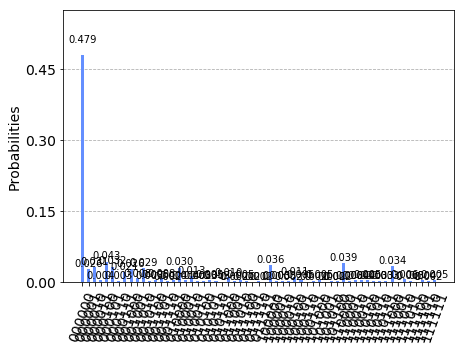

In [192]:
job_manager = IBMQJobManager()
circ = QuantumCircuit(device_backend.configuration().n_qubits, 6)
trotter_circ(circ, [5, 7, 10, 6, 12, 11], unitary_sim = False)
circ.measure([5, 7, 10, 6, 12, 11], list(range(6)))
jobs = job_manager.run([circ], backend=device_backend)
print(jobs.report())
while any(stat != JobStatus.DONE for stat in jobs.statuses()):
    time.sleep(60)
results = jobs.results()
print(jobs.error_messages())
counts_nomit = results.get_counts(0)
plot_histogram(counts_nomit)

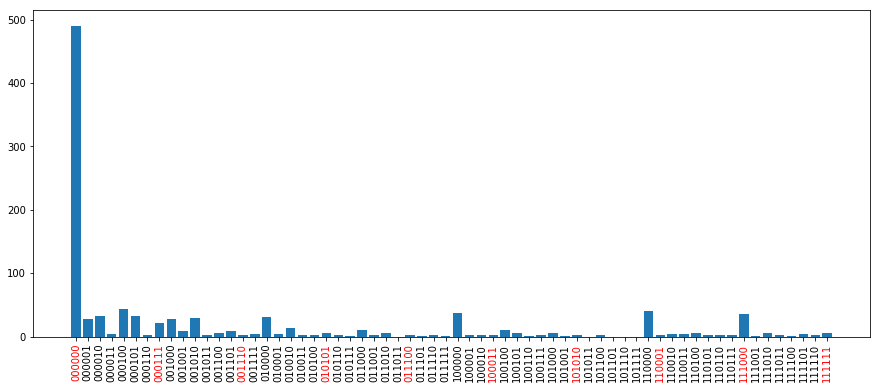

In [223]:
counts_nomit = {dec_to_binary_str(i, 6): counts_nomit.get(dec_to_binary_str(i, 6), 0) for i in range(2**6)}
plt.figure(figsize=(15, 6))
plt.bar(counts_nomit.keys(), [v for v in counts_nomit.values()])
plt.xticks(rotation=90)
[plt.gca().get_xticklabels()[i].set_color("red") for i in range(64) if i%7 == 0]
plt.show()

In [193]:
expectation(counts_nomit, 1024)

0.36328125

# With Mitigation

In [271]:
def mitigation_and_p_list(process_mat_dict, n_steps, max_nonid, trhd = 1e-2):
    sig_str = ["I", "X", "Y", "Z"]
    mitigation_list = []
    p_list = [] # The (quasi-)probability that the circuit occurs
    for stp in range(n_steps):
        for itr, (key, val) in enumerate(process_mat_dict.items()):
            temp_list = []
            temp_p = []
            index = np.where(np.abs(np.real(val)) > trhd)[0]
            for i in index:
                if len(mitigation_list) == 0:
                    temp_p.append(val[i])
                    if key[0] != 'B':
                        temp_list.append({'%d'%stp + key: '%s%s'%(sig_str[(i// 4)%4], sig_str[i%4])})
                    else:
                        temp_list.append({'%d'%stp + key: '%s%s%s'%(sig_str[i//16], sig_str[(i// 4)%4], sig_str[i%4])})
                else:
                    for j, d in enumerate(mitigation_list):
                        dic = d.copy()
                        if key[0] != 'B':
                            dic['%d'%stp + key] = '%s%s'%(sig_str[(i// 4)%4], sig_str[i%4])
                        else:
                            dic['%d'%stp + key] = '%s%s%s'%(sig_str[i//16], sig_str[(i// 4)%4], sig_str[i%4])
                        if len([v for v in dic.values() if v != 'II' and v != 'III']) <= max_nonid:
                            temp_list.append(dic)
                            prod = p_list[j]*val[i]
                            temp_p.append(prod[0])
            p_list = temp_p             
            mitigation_list = temp_list
    return [mitigation_list, p_list]
    
def error_mitigated_circuits_two_layers(target_indices, g, alpha, T, n_steps, device_backend, process_mat_dict, max_nonid, trhd = 1e-2, max_jobs = None):
    
    deltaT = T/n_steps
    
    mitigation_list, p_list = mitigation_and_p_list(process_mat_dict, n_steps, max_nonid, trhd = 1e-2)
    if max_jobs != None:
        ind_top_k = np.argsort(np.abs(np.real(p_list)))[-max_jobs:][::-1]
        mitigation_list = [mitigation_list[ind] for ind in ind_top_k]
        p_list = [p_list[ind] for ind in ind_top_k]
        
    assert(len(mitigation_list) == len(p_list)), "The lengths of mitigation gate list and that of p list do not match."
    print("The sum of coefficients:", np.sum(p_list))
    print("Number of mitigation combinations: %d" %len(mitigation_list))
    
    # Execute circuits
    job_manager = IBMQJobManager()
    circs = []
    for mit_dict in mitigation_list:
        circ = QuantumCircuit(device_backend.configuration().n_qubits, 6)
        circ = physical_trotter_circ(circ, target_indices, g, alpha, T, n_steps, mit_dict, unitary_sim = False)
        circ.measure(target_indices, list(range(6)))
        circs.append(circ)
    jobs = job_manager.run(circs, backend=device_backend)
    print(jobs.report())
    while any(stat != JobStatus.DONE for stat in jobs.statuses()):
        time.sleep(60)
    
    print(jobs.error_messages())
    return [jobs.results(), p_list]

In [284]:
results, p_list = error_mitigated_circuits_two_layers([5, 7, 10, 6, 12, 11], g, alpha, 0.1, 1, device_backend, 
                        {"EXY0": chi_eps_inv_exy, "EXY1": chi_eps_inv_exy1, "EXY2": chi_eps_inv_exy2, "B0":chi_eps_inv_plaquette, "B1":chi_eps_inv_plaquette1,
                        "SWAP0": chi_eps_inv_swap, "SWAP1": chi_eps_inv_swap}, 1, 1e-2, 20000)

The sum of coefficients: (0.12666927489764324-1.226138419887756e-17j)
Number of mitigation combinations: 89
Job set name: 2020-04-12T01:32:57.269335
          ID: 12403b634aaa480e86de5c778fabeb1a-15866551772693353
        tags: []
Summary report:
       Total jobs: 1
  Successful jobs: 0
      Failed jobs: 0
   Cancelled jobs: 0
     Running jobs: 0
     Pending jobs: 1

Detail report:
  experiments: 0-88
    job index: 0
    status: job is being initialized
None


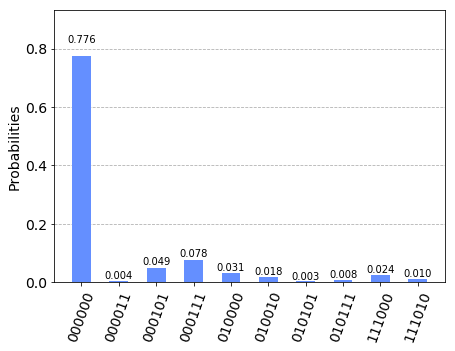

In [281]:
dist = {dec_to_binary_str(i, 6): 0. for i in range(2**6)}
for i, p in enumerate(p_list):
    counts = results.get_counts(i)
    for key in counts.keys():
        dist[key] += np.real(p)*counts[key]
plot_histogram({key: val for key, val in dist.items() if val > 0})

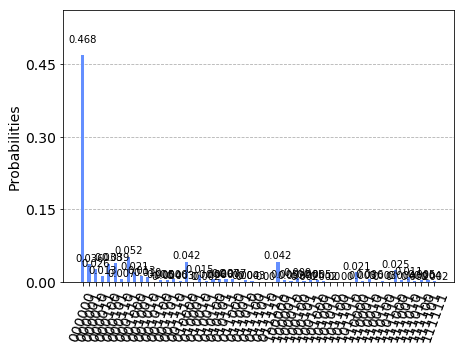

In [283]:
plot_histogram(results.get_counts(0))

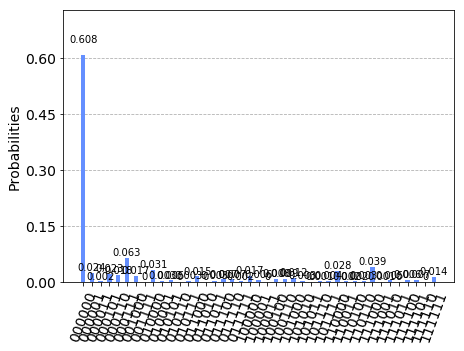

In [273]:
dist = {dec_to_binary_str(i, 6): 0. for i in range(2**6)}
cnt = 0
for i, jid in enumerate(["5e9161bd36f2f30012ed9e34", "5e9161c2d872fe0011cf32c4", "5e9161c61fd9750011c96f2c", "5e9161ca103fad001104e719", 
            "5e9161d2bb7d8500119d0f6a", "5e9161d236f2f30012ed9e36", "5e9161d81fd9750011c96f2e", "5e9161da36f2f30012ed9e37", 
            "5e9161df1335a70011a185e9", "5e9161e2ca7bba0011c43f2a", "5e9161e41335a70011a185ea", "5e9161e1ca7bba0011c43f29"]):
    result = device_backend.retrieve_job(jid).result()
    for j in range(900):
        try:
            counts = result.get_counts(j)
        except:
            break
        p = p_list[i*900+j]
        for key in counts.keys():
            dist[key] += np.real(p)*counts[key]
plot_histogram({key: val for key, val in dist.items() if val > 0})

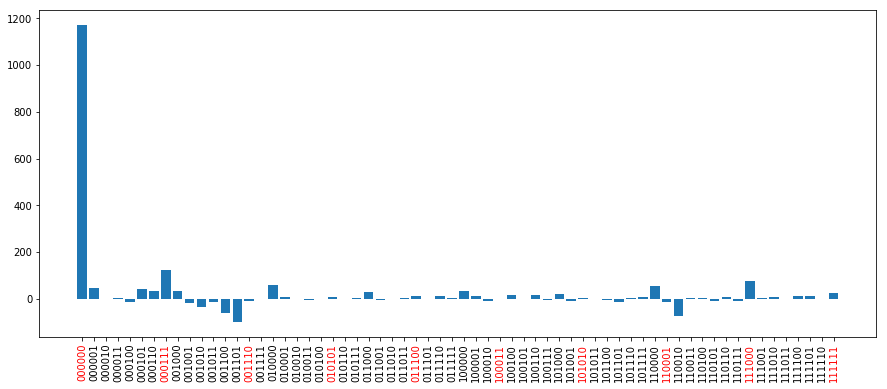

0.7480657076594367


In [275]:
plt.figure(figsize=(15, 6))
plt.bar(dist.keys(), [v for v in dist.values()])
plt.xticks(rotation=90)
[plt.gca().get_xticklabels()[i].set_color("red") for i in range(64) if i%7 == 0]
plt.show()
print(expectation(dist, sum(dist.values())))

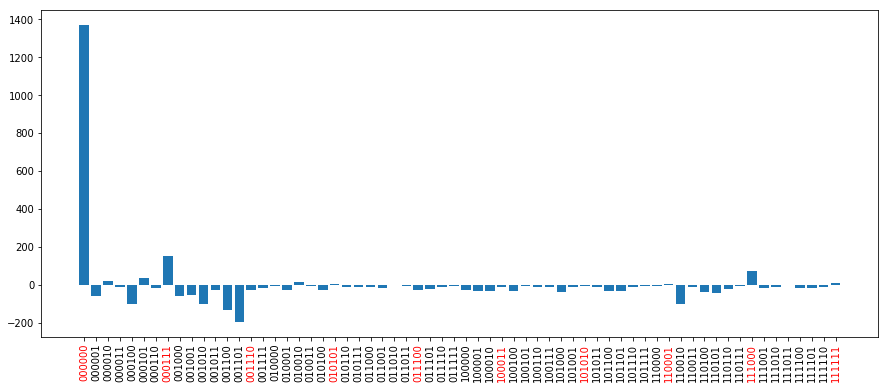

[9.53012641]


In [225]:
plt.figure(figsize=(15, 6))
plt.bar(dist.keys(), [v[0] for v in dist.values()])
plt.xticks(rotation=90)
[plt.gca().get_xticklabels()[i].set_color("red") for i in range(64) if i%7 == 0]
plt.show()
print(expectation(dist, sum(dist.values())))

# Exact

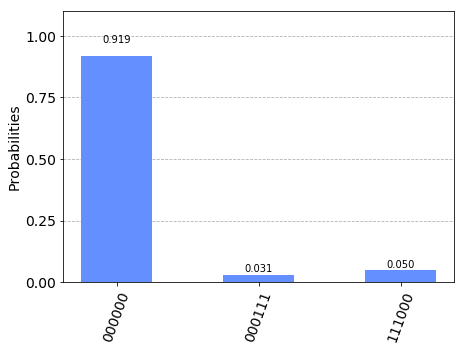

In [137]:
circ = QuantumCircuit(6, 6)
trotter_circ(circ, [0, 1, 2, 3, 4, 5], unitary_sim = False)
circ.measure([0, 1, 2, 3, 4, 5], list(range(6)))
job = execute(circ, backend=backend)
result = job.result()
counts = result.get_counts(0)
plot_histogram(counts)

In [139]:
expectation(counts, 1024)

0.837890625

In [218]:
m_list, p_list = mitigation_and_p_list(
                        {"EXY0": chi_eps_inv_exy, "EXY1": chi_eps_inv_exy1, "EXY2": chi_eps_inv_exy2, "B0":chi_eps_inv_plaquette, "B1":chi_eps_inv_plaquette1,
                        "SWAP0": chi_eps_inv_swap, "SWAP1": chi_eps_inv_swap}, 1, 1, 1e-2)
print(np.sum(p_list))

89
(0.12666927489764324-1.226138419887755e-17j)


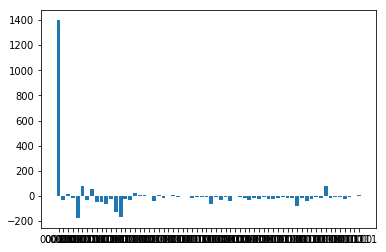

In [191]:
plt.bar(dist.keys(), [v[0] for v in dist.values()])
plt.show()

89


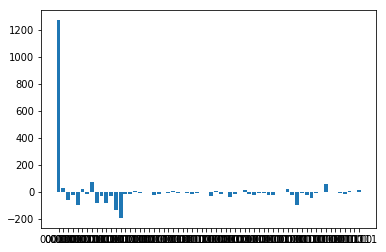

In [157]:
m_list, p_list = mitigation_and_p_list(
                        {"EXY0": chi_eps_inv_exy, "EXY1": chi_eps_inv_exy1, "EXY2": chi_eps_inv_exy2, "B0":chi_eps_inv_plaquette, "B1":chi_eps_inv_plaquette1,
                        "SWAP0": chi_eps_inv_swap, "SWAP1": chi_eps_inv_swap}, 1, 1, 1e-2)
results = device_backend.retrieve_job("5e8f44b41335a70011a1730b").result()
dist_1 = {dec_to_binary_str(i, 6): 0. for i in range(2**6)}
for i, p in enumerate(p_list):
    counts = results.get_counts(i)
    for key in counts.keys():
        dist_1[key] += np.real(p)*counts[key]
#plot_histogram(dist_1)
plt.bar(dist_1.keys(), [v[0] for v in dist_1.values()])
plt.show()

In [266]:
m_list, p_list = mitigation_and_p_list(
                        {"EXY0": chi_eps_inv_exy, "EXY1": chi_eps_inv_exy1, "EXY2": chi_eps_inv_exy2, "B0":chi_eps_inv_plaquette, "B1":chi_eps_inv_plaquette1,
                        "SWAP0": chi_eps_inv_swap, "SWAP1": chi_eps_inv_swap}, 1, 3, 1e-2)
ind_top_10000 = np.argsort(np.abs(np.real(p_list)))[-10000:][::-1]
print(np.sum([p_list[ind] for ind in ind_top_10000]))
np.sum(p_list)

(1.4804974848222576-3.4919592841739055e-19j)


(1.2375178523090797-5.249875798308733e-18j)

# Measurement Mitigation

Status @ 0 seconds
JobStatus.VALIDATING
Status @ 30 seconds
JobStatus.QUEUED
Status @ 60 seconds
JobStatus.QUEUED
Status @ 90 seconds
JobStatus.QUEUED
Status @ 120 seconds
JobStatus.QUEUED
Status @ 150 seconds
JobStatus.QUEUED
Status @ 180 seconds
JobStatus.QUEUED
Status @ 210 seconds
JobStatus.QUEUED
Status @ 240 seconds
JobStatus.RUNNING
Status @ 270 seconds
JobStatus.RUNNING
Status @ 300 seconds
JobStatus.RUNNING
Status @ 330 seconds
JobStatus.RUNNING
JobStatus.DONE


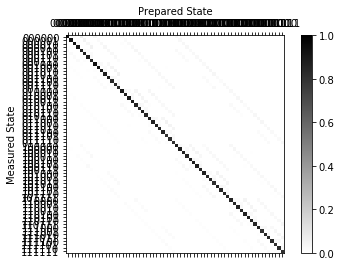

In [209]:
### create and execute the calibration circuits
meas_calibs, state_labels = complete_meas_cal([5, 7, 10, 6, 12, 11], circlabel='mcal')
job = execute(meas_calibs, backend=device_backend, shots=1024)
lapse = 0
interval = 30
while job.status() != JobStatus.DONE:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    time.sleep(interval)
    lapse += 1
print(job.status())
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
#print(meas_fitter.cal_matrix)
meas_fitter.plot_calibration()

89


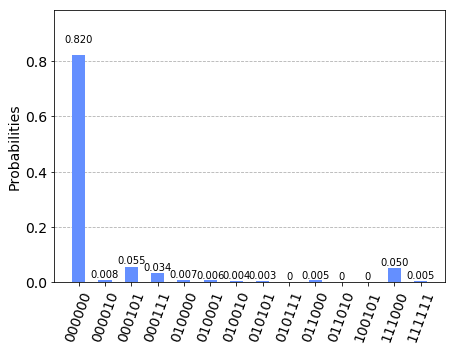

In [214]:
# Get the filter object
meas_filter = meas_fitter.filter

# Get the results
job = device_backend.retrieve_job("5e8ff04fbb7d8500119d027b")
m_list, p_list = mitigation_and_p_list(
                        {"EXY0": chi_eps_inv_exy, "EXY1": chi_eps_inv_exy1, "EXY2": chi_eps_inv_exy2, "B0":chi_eps_inv_plaquette, "B1":chi_eps_inv_plaquette1,
                        "SWAP0": chi_eps_inv_swap, "SWAP1": chi_eps_inv_swap}, 1, 1, 1e-2)

dist_mit = {dec_to_binary_str(i, 6): 0. for i in range(2**6)}
for i, p in enumerate(p_list):
    # Results with mitigation
    mitigated_counts = meas_filter.apply(job.result().get_counts(i))
    for key in mitigated_counts.keys():
        dist_mit[key] += np.real(p)*mitigated_counts[key]
plot_histogram({key: val for key, val in dist_mit.items() if val > 0})

### Kill queued (or any invalid) jobs 

In [169]:
from qiskit.providers.ibmq import api
print(device_backend.jobs())
for job in device_backend.jobs():
    job.cancel()

[IBMQJob(_api=<qiskit.providers.ibmq.api.clients.account.AccountClient object at 0x00000293C0B934E0>, _api_status=<ApiJobStatus.ERROR_VALIDATING_JOB: 'ERROR_VALIDATING_JOB'>, _backend=<IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, _backend_info=namespace(id='5d7bbf8e02c24474838ac5ee', name='ibmq_johannesburg'), _cancelled=False, _creation_date=datetime.datetime(2020, 4, 10, 2, 49, 39, 737000, tzinfo=datetime.timezone.utc), _error=None, _job_error_msg=None, _job_id='5e8fdec31fd9750011c96217', _name='2020-04-10T02:45:44.544702_53_', _qobj=None, _queue_info=None, _result=None, _status=<JobStatus.ERROR: 'job incurred error'>, _tags=['ibmq_jobset_e3db48ea65a3473fad97aade5c98af37-1586486744544703_'], _time_per_step=None, _use_object_storage=True, hub_info={'hub': {'name': 'ibm-q-ornl'}, 'group': {'name': 'hep-qis'}, 'project': {'name': 'brookhaven'}}, kind=<ApiJobKind.QOBJECT_STORAGE: 'q-object-external-storage'>, share_level='none', us

IBMQJobApiError: "Error cancelling job: '400 Client Error: Bad Request for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q-ornl/Groups/hep-qis/Projects/brookhaven/Jobs/5e8fdec31fd9750011c96217/cancel. Job not running., Error code: 3209.'"